In [4]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pickle
import pandas as pd

In [5]:
def get_quantile(samples,q,dim=1):
    return np.quantile(samples,q,axis=dim)#.cpu().numpy()
1

1

In [6]:
dataset = 'airquality' #choose 'healthcare' or 'airquality'
# dataset = 'healthcare'
datafolder = 'pm25_outsample_20250201_124807'#'pretrained' # set the folder name
nsample = 100 # number of generated sample

path = './save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk' 
with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load(f)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length

if dataset == 'airquality':
    path = 'data/pm25/pm25_meanstd.pk'
    with open(path, 'rb') as f:
        train_mean,train_std = pickle.load(f)
    # train_std_cuda = torch.from_numpy(train_std).cuda()
    # train_mean_cuda = torch.from_numpy(train_mean).cuda()
    all_target_np=(all_target_np*train_std+train_mean)
    samples=(samples.cpu().numpy()*train_std+train_mean)
    
elif dataset == 'healthcare':
    path = 'data/metr_la/metr_meanstd.pk'
    with open(path, 'rb') as f:
        train_mean,train_std = pickle.load(f)
    # train_std_cuda = torch.from_numpy(train_std).cuda()
    # train_mean_cuda = torch.from_numpy(train_mean).cuda()
    all_target_np=(all_target_np*train_std+train_mean)
    samples=(samples.cpu().numpy()*train_std+train_mean)

In [7]:

qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

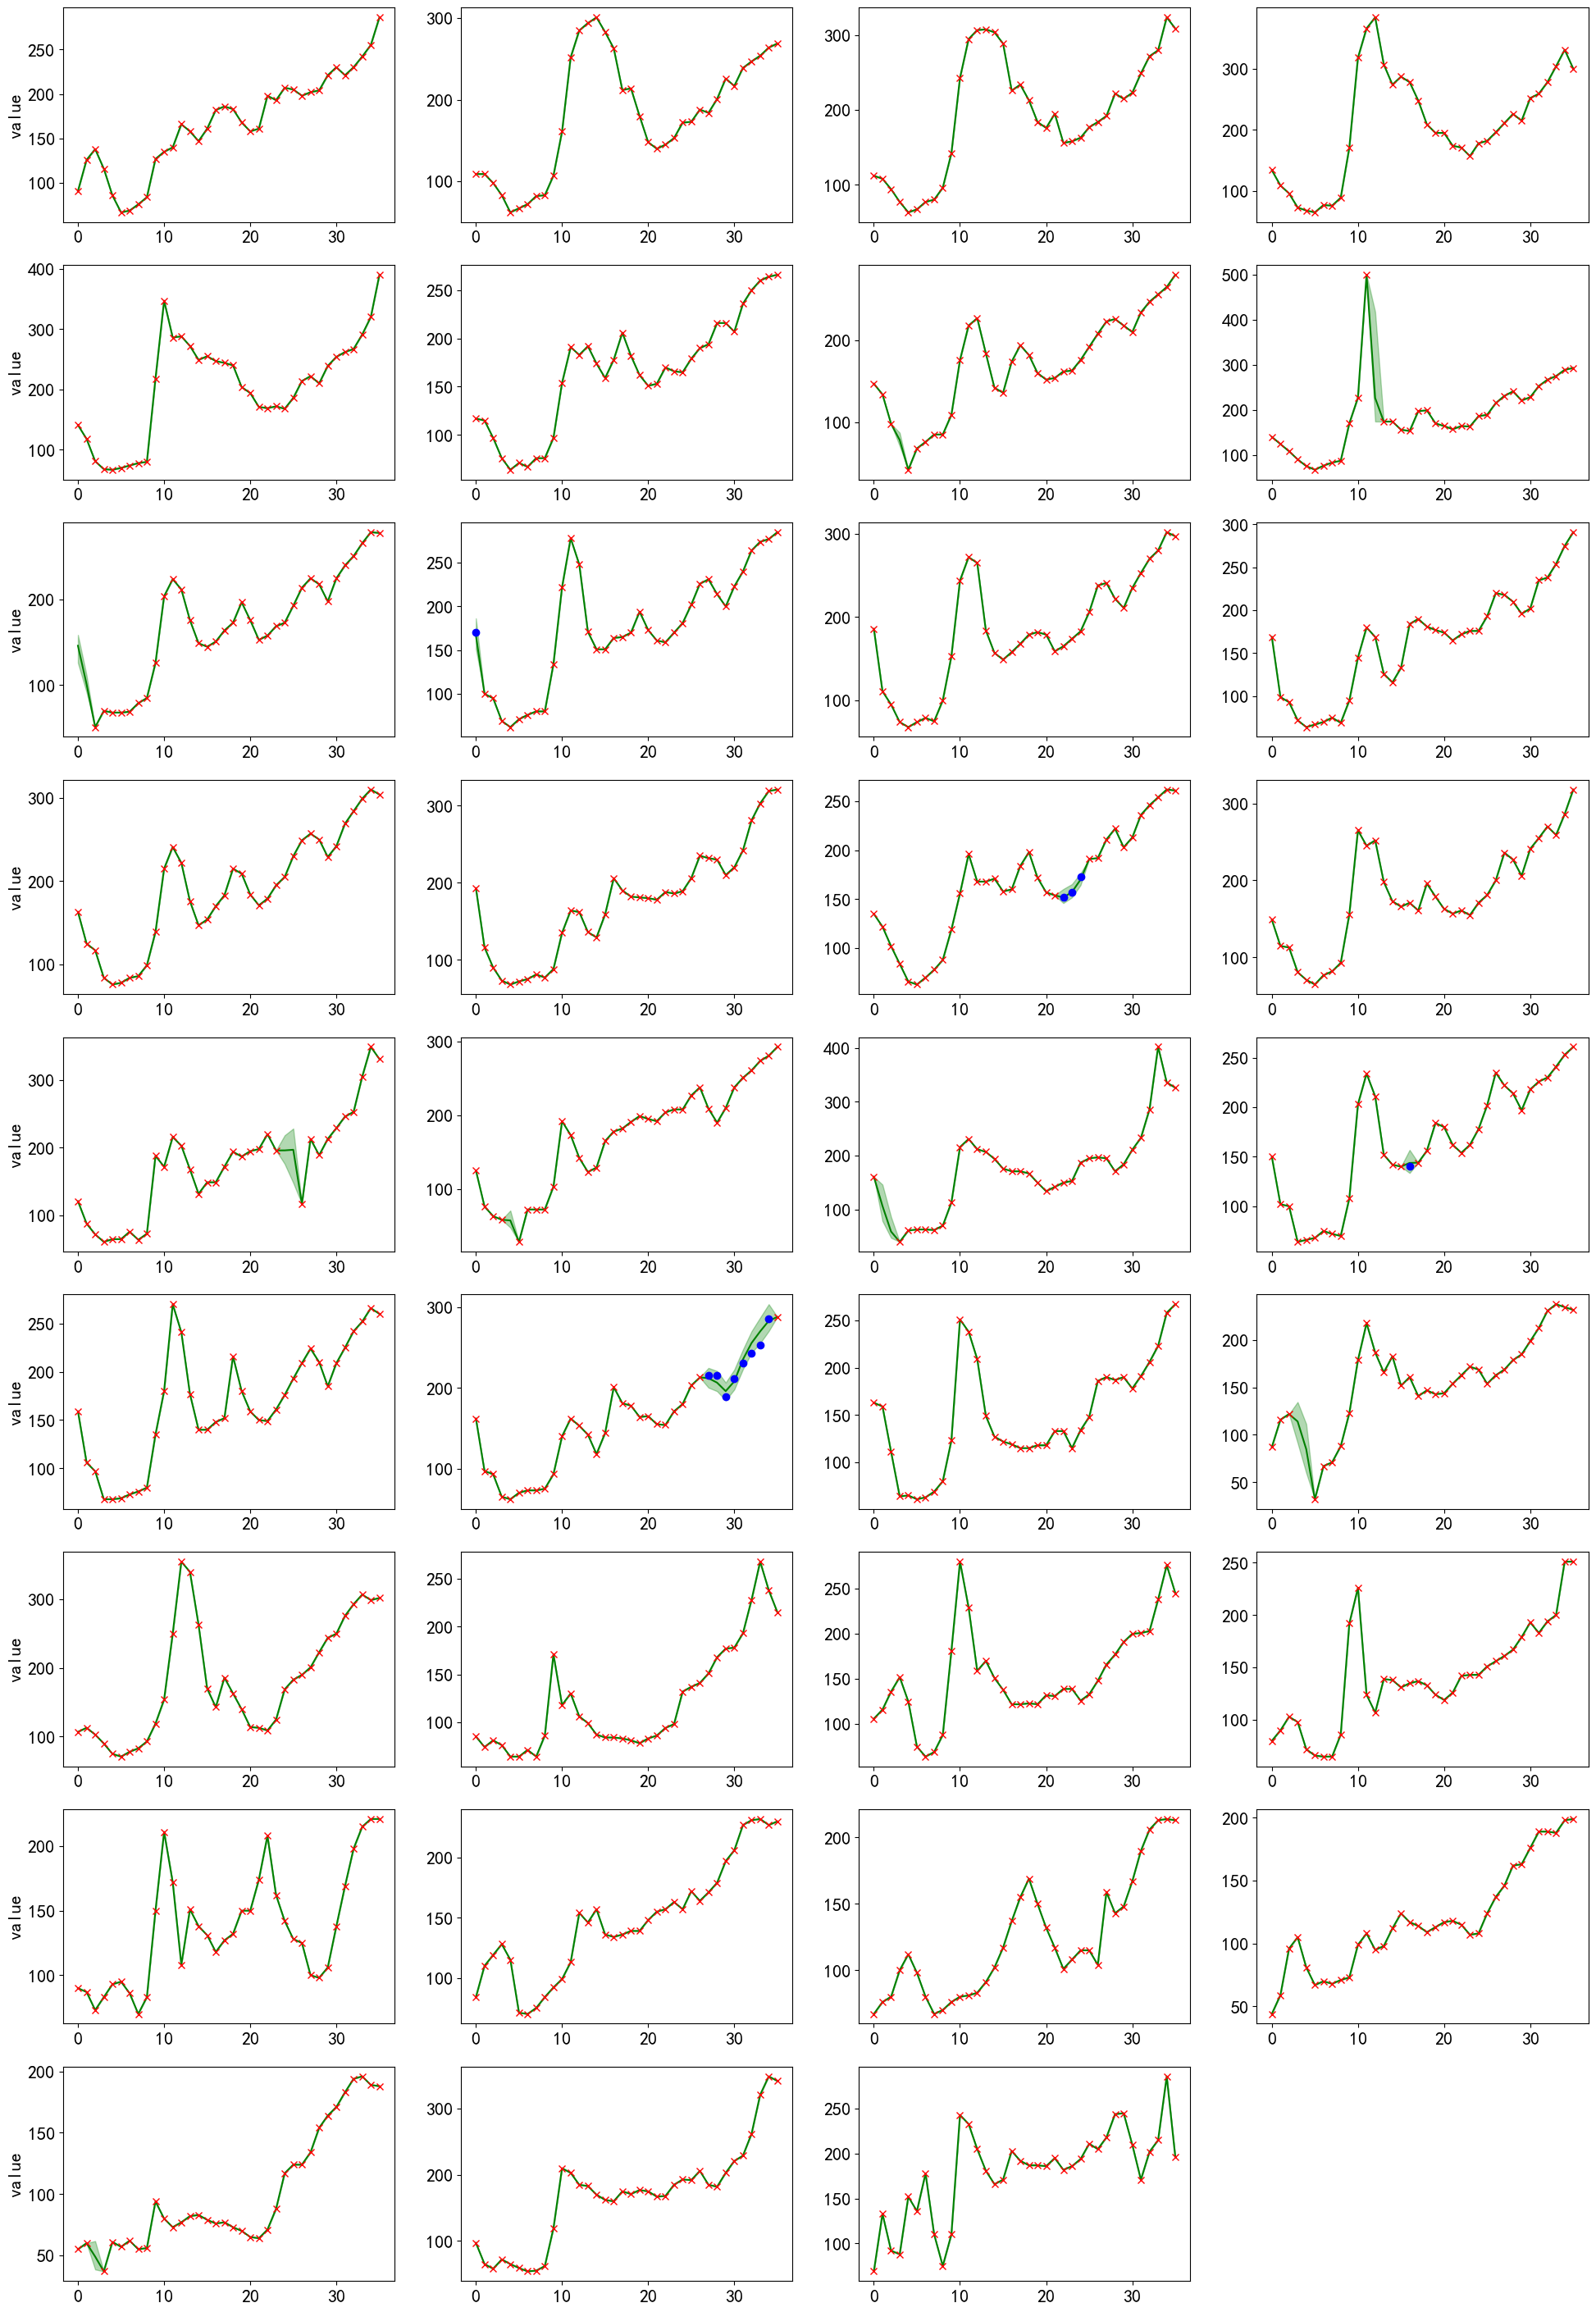

In [8]:
###healthcare###
dataind = 3 #change to visualize a different time-series sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')


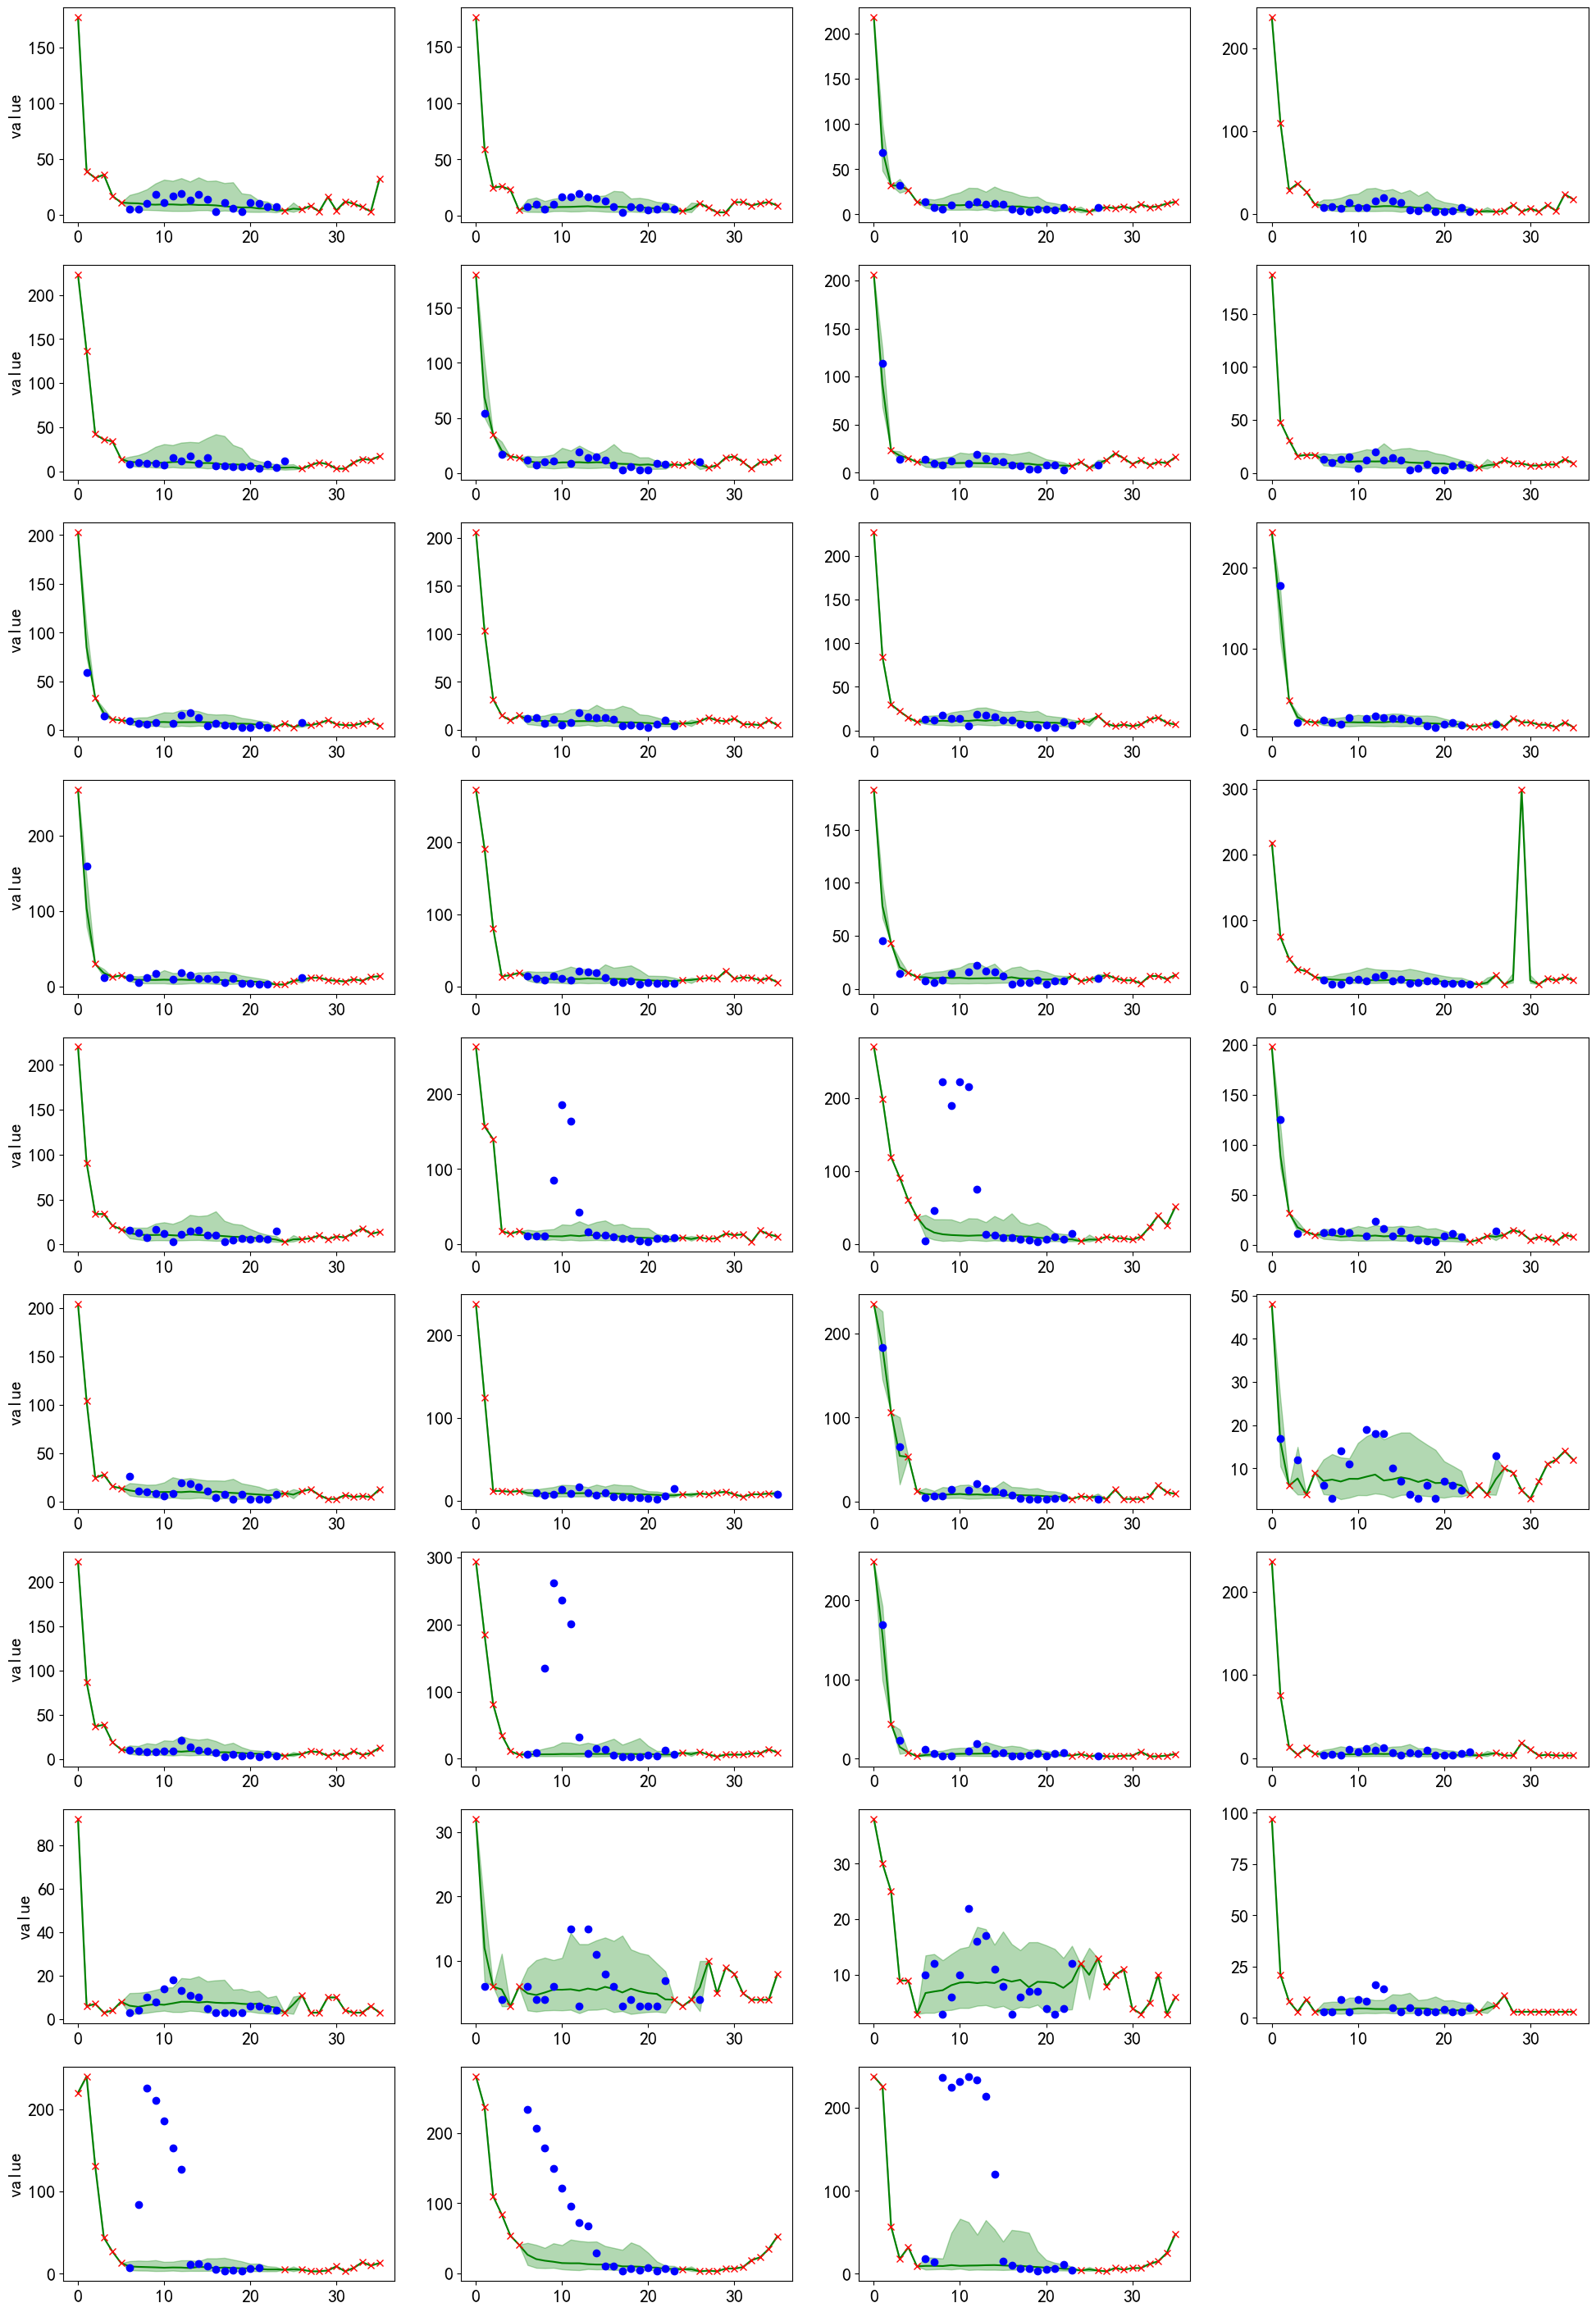

In [9]:
###airquality###
dataind = 5 #change to visualize a different sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')
# plt.savefig('prediction.png')

In [23]:
k=0
list_mae = []
for k in range(36):
    mask = all_evalpoint_np[:,:,k]!=0
    MAE = np.abs(all_target_np[:,:,k][mask] - quantiles_imp[2][:,:,k][mask]).mean()
    print(f'{k}: {(MAE-train_mean[k])/train_std[k]}')
    # su += (MAE-train_mean[k])/train_std[k]
    list_mae.append(MAE)

0: -1.0073667910305952
1: -0.9385109263511758
2: -1.0328148401792607
3: -0.996891665870357
4: -0.9875481775255261
5: -0.9986304885024657
6: -1.008538447860482
7: -1.021203528861518
8: -0.987257785574683
9: -1.0225464129504391
10: -1.0772904141113184
11: -0.9651932238934399
12: -0.9736324745768681
13: -0.956610566967013
14: -1.0320976251387022
15: -1.0169080693009525
16: -0.9772539611090221
17: -1.016995363091148
18: -0.9852534338587503
19: -1.000498437554185
20: -1.037257601615267
21: -0.9794417747111887
22: -0.9654576317793742
23: -0.8960034767961674
24: -0.9616609336124451
25: -0.9571351891388347
26: -0.9490990899932559
27: -0.8638784548121775
28: -0.9186682447821717
29: -0.8575441500257651
30: -0.8858797742635621
31: -0.8123535506258681
32: -0.9974557205101691
33: -0.9718632313141176
34: -0.9484067866978977
35: -0.9985303510240197


In [24]:
mask = all_given_np[:,:,k]!=0
np.mean((all_target_np[:,:,k][mask] - quantiles_imp[2][:,:,k][mask])**2)

0.0

In [27]:
dd = np.std(samples.transpose(1,0,2,3)*all_evalpoint_np,axis=0)

In [28]:
dd.mean()

1.8369747168378183

In [29]:
aa=samples.transpose(1,0,2,3)*all_evalpoint_np

7.813179366786149


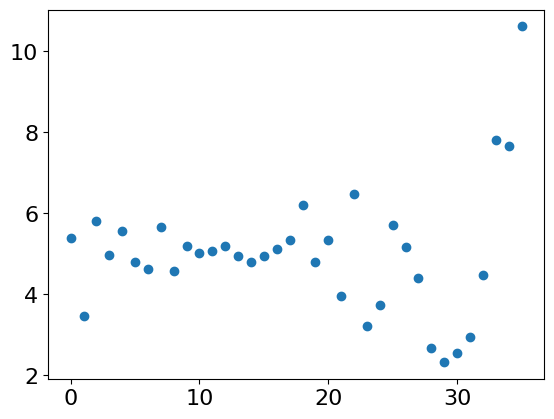

In [30]:
ddd = samples.transpose(1,0,2,3)*all_evalpoint_np
ddd[0,5,0,:] = 170



print(np.std(ddd,axis=0)[5,20,0])
np.std(ddd[:,5,20,0])


# ddd.shape
plt.plot(np.mean(np.std(ddd, axis=0), axis=1)[5],'o')

In [31]:
np.mean(np.std(ddd, axis=0))

1.842704658040668

In [32]:
ddd.shape

(100, 82, 36, 36)

In [33]:
std_1 = np.mean(np.std(ddd[:,:,:,[2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]], axis=0))
std_2 = np.mean(np.std(ddd[:,:,:,[0,  1, 22, 23, 24, 26, 27, 28, 29, 30, 31]], axis=0))
std_3 = np.mean(np.std(ddd[:,:,:,[25, 32, 33, 34, 35]], axis=0))

print(std_1, std_2, std_3)

1.6266080697917502 1.722508303163681 2.9715229917657093
